In [ ]:
import os
import io
import pandas as pd
import numpy as np
from google.cloud import vision_v1
from pythainlp import word_tokenize
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, f1_score
import seaborn as sns
import difflib
from sklearn.metrics import classification_report, log_loss
from sklearn.metrics import precision_score

In [9]:
# โหลดข้อมูลจากไฟล์ CSV
try:
    data = pd.read_csv('medicine_dataset1.csv', encoding='utf-8', on_bad_lines='warn')
except UnicodeDecodeError:
    data = pd.read_csv('medicine_dataset1.csv', encoding='ISO-8859-1', on_bad_lines='warn')

C:\Users\User\AppData\Local\Temp\ipykernel_8712\2450574255.py:3: DtypeWarning: Columns (26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('medicine_dataset1.csv', encoding='utf-8', on_bad_lines='warn')


In [10]:
df1 = pd.DataFrame(data, columns=['use0', 'Therapeutic Class', 'sideEffect1'])
df1

,use0,Therapeutic Class,sideEffect1
0,Treatment of Bacterial infections,ANTI INFECTIVES,Nausea
1,Treatment of Bacterial infections,ANTI INFECTIVES,Nausea
2,Treatment of Bacterial infections,ANTI INFECTIVES,Nausea
3,Treatment of Bacterial infections,ANTI INFECTIVES,Nausea
4,Treatment of Resistance Tuberculosis (TB),ANTI INFECTIVES,Vomiting
...,...,...,...
198511,Treatment of Cough with mucus,RESPIRATORY,Vomiting
198512,Chronic obstructive pulmonary disease (COPD),RESPIRATORY,Headache
198513,Treatment of Common cold,RESPIRATORY,Rash
198514,Treatment of Allergic conditions,RESPIRATORY,Dizziness


In [11]:
# ตั้งค่าคีย์ API ของ Google Cloud
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = r'project-service.json'
client = vision_v1.ImageAnnotatorClient()

In [12]:
# ตั้งค่าพาธของไฟล์รูปภาพ
file_name = 'test18.jpg'
image_folder = 'C:/Users/User/google_vision_ai_demo/image'
image_path = os.path.join(image_folder, file_name)

In [13]:
# อ่านข้อมูลรูปภาพ
with io.open(image_path, 'rb') as image_file:
    content = image_file.read()

image = vision_v1.types.Image(content=content)

In [14]:
# สร้าง dataframe สำหรับการประมวลผลโมเดล
df = pd.DataFrame(data, columns=['use0', 'Therapeutic Class', 'sideEffect1'])
df['use0'] = df['use0'].apply(lambda x: ','.join(str(x).split()))

In [15]:
df

,use0,Therapeutic Class,sideEffect1
0,"Treatment,of,Bacterial,infections",ANTI INFECTIVES,Nausea
1,"Treatment,of,Bacterial,infections",ANTI INFECTIVES,Nausea
2,"Treatment,of,Bacterial,infections",ANTI INFECTIVES,Nausea
3,"Treatment,of,Bacterial,infections",ANTI INFECTIVES,Nausea
4,"Treatment,of,Resistance,Tuberculosis,(TB)",ANTI INFECTIVES,Vomiting
...,...,...,...
198511,"Treatment,of,Cough,with,mucus",RESPIRATORY,Vomiting
198512,"Chronic,obstructive,pulmonary,disease,(COPD)",RESPIRATORY,Headache
198513,"Treatment,of,Common,cold",RESPIRATORY,Rash
198514,"Treatment,of,Allergic,conditions",RESPIRATORY,Dizziness


In [16]:
# ทำการตรวจจับข้อความในรูปภาพ
response = client.text_detection(image=image)
texts = response.text_annotations

In [17]:
#สำฟังก์ชันหรับกรองเฉพาะตัวอักษรและตัวเลข รวมถึงภาษาไทย
def filter_alnum_thai(text):
    return ''.join(filter(lambda x: x.isalnum() or '\u0E00' <= x <= '\u0E7F', text))

In [18]:
# ฟังก์ชันสำหรับประมวลผลข้อความ OCR
def process_text(text):
    return ' '.join(text.split())

In [19]:
# def remove_duplicate_words(text):
#     # ใช้ regular expressions เพื่อหาคำทั้งหมดในข้อความ
#     words = re.findall(r'\b\w+\b', text)
    
#     # ใช้ OrderedDict เพื่อเก็บคำที่ไม่ซ้ำกันและรักษาลำดับเดิม
#     unique_words = list(OrderedDict.fromkeys(words))
    
#     # รวมคำที่ไม่ซ้ำกันกลับเป็นข้อความเดียว
#     return ' '.join(unique_words)  # ใช้ ''.join เพื่อรวมคำกลับเป็นข้อความเดียวไม่มีเว้นวรรค

In [20]:
# ดึงข้อความ OCR
full_text = ','.join([text.description.replace(',', ' ') for text in texts])
filtered_text = process_text(full_text)
cleaned_text = filtered_text.replace("  ", " ").replace(" ,", ",").replace(", ", ",")
cleaned_text1 = re.sub(r',+', ',', cleaned_text)
cleaned_text2 = re.sub(r'\.+', ' ', cleaned_text1)

In [21]:
print(full_text)

PHARMACY MEDICINE
KEEP OUT OF REACH OF CHILDREN
Bisolvon
DRY
dextromethorphan hydrobromide monohydrate 10.5mg
Honey Lime Flavour
20 PASTILLES
DRY COUGH PASTILLES
Rapid Relief from Dry  Irritating Coughs
Helps Soothe the Throat
Gluten-free
AUST R 191459,PHARMACY,MEDICINE,KEEP,OUT,OF,REACH,OF,CHILDREN,Bisolvon,DRY,dextromethorphan,hydrobromide,monohydrate,10.5mg,Honey,Lime,Flavour,20,PASTILLES,DRY,COUGH,PASTILLES,Rapid,Relief,from,Dry, ,Irritating,Coughs,Helps,Soothe,the,Throat,Gluten,-,free,AUST,R,191459


In [22]:
filtered_text

'PHARMACY MEDICINE KEEP OUT OF REACH OF CHILDREN Bisolvon DRY dextromethorphan hydrobromide monohydrate 10.5mg Honey Lime Flavour 20 PASTILLES DRY COUGH PASTILLES Rapid Relief from Dry Irritating Coughs Helps Soothe the Throat Gluten-free AUST R 191459,PHARMACY,MEDICINE,KEEP,OUT,OF,REACH,OF,CHILDREN,Bisolvon,DRY,dextromethorphan,hydrobromide,monohydrate,10.5mg,Honey,Lime,Flavour,20,PASTILLES,DRY,COUGH,PASTILLES,Rapid,Relief,from,Dry, ,Irritating,Coughs,Helps,Soothe,the,Throat,Gluten,-,free,AUST,R,191459'

In [23]:
cleaned_text

'PHARMACY MEDICINE KEEP OUT OF REACH OF CHILDREN Bisolvon DRY dextromethorphan hydrobromide monohydrate 10.5mg Honey Lime Flavour 20 PASTILLES DRY COUGH PASTILLES Rapid Relief from Dry Irritating Coughs Helps Soothe the Throat Gluten-free AUST R 191459,PHARMACY,MEDICINE,KEEP,OUT,OF,REACH,OF,CHILDREN,Bisolvon,DRY,dextromethorphan,hydrobromide,monohydrate,10.5mg,Honey,Lime,Flavour,20,PASTILLES,DRY,COUGH,PASTILLES,Rapid,Relief,from,Dry,,Irritating,Coughs,Helps,Soothe,the,Throat,Gluten,-,free,AUST,R,191459'

In [24]:
cleaned_text1

'PHARMACY MEDICINE KEEP OUT OF REACH OF CHILDREN Bisolvon DRY dextromethorphan hydrobromide monohydrate 10.5mg Honey Lime Flavour 20 PASTILLES DRY COUGH PASTILLES Rapid Relief from Dry Irritating Coughs Helps Soothe the Throat Gluten-free AUST R 191459,PHARMACY,MEDICINE,KEEP,OUT,OF,REACH,OF,CHILDREN,Bisolvon,DRY,dextromethorphan,hydrobromide,monohydrate,10.5mg,Honey,Lime,Flavour,20,PASTILLES,DRY,COUGH,PASTILLES,Rapid,Relief,from,Dry,Irritating,Coughs,Helps,Soothe,the,Throat,Gluten,-,free,AUST,R,191459'

In [25]:
cleaned_text2

'PHARMACY MEDICINE KEEP OUT OF REACH OF CHILDREN Bisolvon DRY dextromethorphan hydrobromide monohydrate 10 5mg Honey Lime Flavour 20 PASTILLES DRY COUGH PASTILLES Rapid Relief from Dry Irritating Coughs Helps Soothe the Throat Gluten-free AUST R 191459,PHARMACY,MEDICINE,KEEP,OUT,OF,REACH,OF,CHILDREN,Bisolvon,DRY,dextromethorphan,hydrobromide,monohydrate,10 5mg,Honey,Lime,Flavour,20,PASTILLES,DRY,COUGH,PASTILLES,Rapid,Relief,from,Dry,Irritating,Coughs,Helps,Soothe,the,Throat,Gluten,-,free,AUST,R,191459'

In [26]:
# แบ่งข้อมูลเป็น train และ test set
X_train, X_test, y_train, y_test = train_test_split(df['use0'], df['Therapeutic Class'], test_size=0.2, random_state=42)

In [27]:
# ใช้ Tokenizer เพื่อแปลงข้อความเป็นลำดับตัวเลข
tokenizer = Tokenizer(num_words=7000)
tokenizer.fit_on_texts(X_train)

In [29]:
# แปลงข้อความเป็นลำดับและทำ padding
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [36]:
X_train_seq

[[2, 1, 72],
 [89],
 [71],
 [24, 19, 3],
 [4, 3],
 [2, 1, 28, 5],
 [2, 1, 33, 47],
 [29, 27],
 [2, 1, 4, 3],
 [2, 1, 32],
 [42, 43],
 [2, 1, 58],
 [14, 9, 12, 13],
 [5, 7],
 [2, 1, 4, 3],
 [2, 1, 4, 3],
 [2, 1, 40, 41],
 [2, 1, 21, 17, 22, 20, 16, 15, 23],
 [2, 1, 4, 3],
 [2, 1, 10, 6, 8, 11, 6],
 [4, 3],
 [2, 1, 18, 44, 56],
 [38],
 [2, 1, 28, 5],
 [30],
 [2, 1, 14, 9, 12, 13],
 [38],
 [2, 1, 14, 9, 12, 13],
 [2, 1, 4, 3],
 [2, 1, 66, 8],
 [2, 1, 35, 36],
 [2, 1, 14, 9, 12, 13],
 [2, 1, 60, 5],
 [2, 1, 4, 3],
 [2, 1, 4, 3],
 [2, 1, 4, 3],
 [2, 1, 4, 3],
 [2, 1, 79, 80, 33],
 [5, 7],
 [2, 1, 28, 5],
 [2, 1, 10, 6, 8, 11, 6],
 [2, 1, 5, 16, 15, 34, 39],
 [46, 51, 50, 8, 52],
 [5, 7],
 [2, 1, 4, 3],
 [2, 1, 4, 3],
 [5, 7],
 [2, 1, 4, 3],
 [146],
 [2, 1, 10, 6, 8, 11, 6],
 [2, 1, 116],
 [25, 24, 3],
 [2, 1, 46, 51, 50, 8, 52],
 [2, 1, 4, 3],
 [2, 1, 79, 80, 33],
 [71],
 [2, 17, 49, 1, 40, 41],
 [5, 7],
 [241, 242, 8],
 [2, 1, 92],
 [2, 1, 9, 31],
 [46, 51, 50, 8, 52],
 [2, 1, 4, 3],
 [2, 

In [37]:
X_test_seq

[[2, 1, 14, 9, 12, 13],
 [2, 1, 4, 26, 3],
 [2, 1, 4, 3],
 [2, 1, 33, 47],
 [2, 1, 24, 3],
 [5, 7],
 [2, 1, 4, 3],
 [131],
 [35, 36],
 [2, 1, 70],
 [2, 1, 25, 4, 3],
 [2, 1, 26, 3],
 [2, 1, 29, 27],
 [2, 1, 4, 3],
 [24, 19, 3],
 [4, 3],
 [2, 1, 10, 6, 8, 11, 6],
 [5, 7],
 [2, 1, 68, 42, 43],
 [2, 1, 5, 16, 15, 34, 39],
 [101, 118, 95, 3],
 [2, 1, 18, 44, 56],
 [4, 3],
 [25, 4, 3],
 [5, 7],
 [2, 1, 4, 3],
 [46, 51, 50, 8, 52],
 [2, 1, 33],
 [2, 1, 58],
 [34, 88],
 [2, 1, 83, 3],
 [5, 7],
 [2, 1, 10, 6, 8, 11, 6],
 [2, 1, 4, 3],
 [2, 1, 4, 3],
 [2, 1, 32],
 [2, 1, 4, 3],
 [24, 165, 3],
 [2, 1, 28, 5],
 [2, 1, 235],
 [4, 3],
 [2, 1, 62],
 [5, 7],
 [2, 1, 37],
 [2, 1, 28, 5],
 [4, 3],
 [2, 1, 14, 9, 12, 13],
 [5, 7],
 [14, 9, 12, 13],
 [14, 9, 12, 13],
 [2, 1, 54, 55, 45],
 [2, 1, 40, 41],
 [2, 1, 37],
 [2, 1, 40, 41],
 [2, 1, 9, 31],
 [2, 1, 4, 3],
 [2, 1, 21, 17, 22, 20, 16, 15, 23],
 [2, 1, 21, 17, 22, 20, 16, 15, 23],
 [2, 1, 59],
 [2, 1, 83, 3],
 [2, 1, 4, 3],
 [9, 31],
 [19, 3],
 [2,

In [35]:
tokenizer

In [30]:
# กำหนดค่าความยาวของลำดับข้อความ
max_length = 150
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post')



In [31]:
X_train_padded

array([[  2,   1,  72, ...,   0,   0,   0],
       [ 89,   0,   0, ...,   0,   0,   0],
       [ 71,   0,   0, ...,   0,   0,   0],
       ...,
       [136,  72, 163, ...,   0,   0,   0],
       [  5,   7,   0, ...,   0,   0,   0],
       [  2,   1,  40, ...,   0,   0,   0]])

In [32]:
X_train_padded[0]

array([ 2,  1, 72,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [33]:
X_test_padded

array([[ 2,  1, 14, ...,  0,  0,  0],
       [ 2,  1,  4, ...,  0,  0,  0],
       [ 2,  1,  4, ...,  0,  0,  0],
       ...,
       [18,  0,  0, ...,  0,  0,  0],
       [ 2,  1, 66, ...,  0,  0,  0],
       [ 2,  1, 73, ...,  0,  0,  0]])

In [34]:
X_test_padded[0]

array([ 2,  1, 14,  9, 12, 13,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [206]:
# สร้างตัวแปลง LabelEncoder
label_encoder = LabelEncoder()

# แปลง y_train และ y_test เป็นตัวเลข
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# แปลง y_train และ y_test เป็น One-Hot Encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
# แก้ไขชั้นสุดท้ายของโมเดลเป็น softmax

In [207]:

model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=256, input_length=max_length))
model.add(Bidirectional(LSTM(256, return_sequences=False)))
model.add(Dropout(0.7))
model.add(Dense(128, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))


c:\Users\User\google_vision_ai_demo\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [208]:
# คอมไพล์โมเดลใหม่
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [209]:
print(type(X_train_padded))
print(type(y_train))
print(X_train_padded.dtype)
print(y_train.dtype)


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
int32
float64


In [210]:
print(X_train_padded.shape)
print(y_train.shape)

(158812, 150)
(158812, 8)


In [211]:
# เพิ่ม Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [212]:
# เทรนโมเดล
history = model.fit(X_train_padded, y_train, epochs=100, batch_size=32, validation_data=(X_test_padded, y_test), callbacks=[early_stopping])

Epoch 1/100
4963/4963 ━━━━━━━━━━━━━━━━━━━━ 1017s 205ms/step - accuracy: 0.9206 - loss: 0.2664 - val_accuracy: 0.9713 - val_loss: 0.1009
Epoch 2/100
4963/4963 ━━━━━━━━━━━━━━━━━━━━ 976s 197ms/step - accuracy: 0.9701 - loss: 0.1083 - val_accuracy: 0.9728 - val_loss: 0.0991
Epoch 3/100
4963/4963 ━━━━━━━━━━━━━━━━━━━━ 882s 178ms/step - accuracy: 0.9711 - loss: 0.1039 - val_accuracy: 0.9720 - val_loss: 0.0990
Epoch 4/100
4963/4963 ━━━━━━━━━━━━━━━━━━━━ 889s 179ms/step - accuracy: 0.9713 - loss: 0.1026 - val_accuracy: 0.9707 - val_loss: 0.0969
Epoch 5/100
4963/4963 ━━━━━━━━━━━━━━━━━━━━ 896s 181ms/step - accuracy: 0.9717 - loss: 0.0994 - val_accuracy: 0.9731 - val_loss: 0.0961
Epoch 6/100
4963/4963 ━━━━━━━━━━━━━━━━━━━━ 896s 181ms/step - accuracy: 0.9721 - loss: 0.0995 - val_accuracy: 0.9714 - val_loss: 0.0964
Epoch 7/100
4963/4963 ━━━━━━━━━━━━━━━━━━━━ 886s 178ms/step - accuracy: 0.9726 - loss: 0.0973 - val_accuracy: 0.9731 - val_loss: 0.0955
Epoch 8/100
4963/4963 ━━━━━━━━━━━━━━━━━━━━ 890s 179ms/

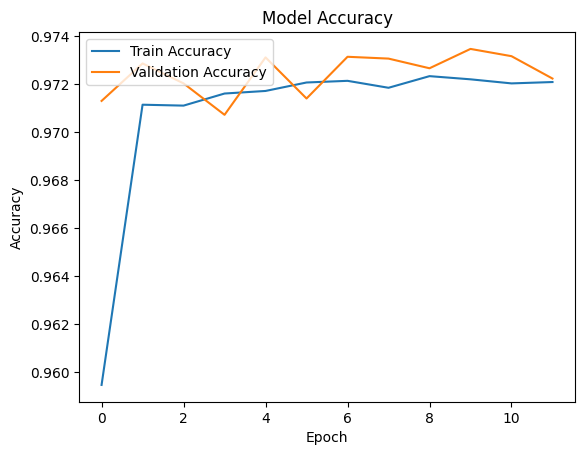

In [213]:
# สร้างกราฟสำหรับ accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

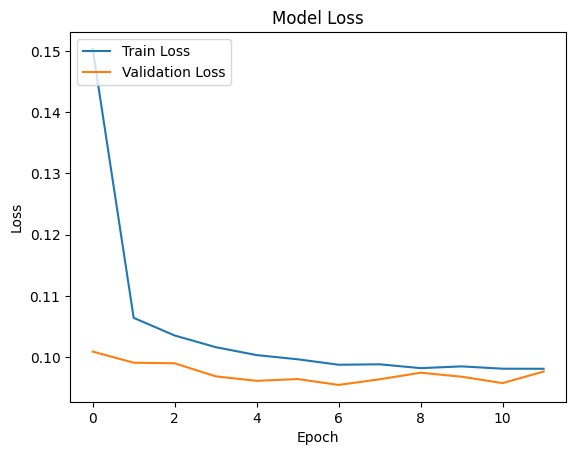

In [214]:
# สร้างกราฟสำหรับ loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [215]:
# ทำนายบนชุดทดสอบ
y_pred = model.predict(X_test_padded)
y_pred_class = np.argmax(y_pred, axis=1)  # ใช้เพื่อทำ classification report
y_test_class = np.argmax(y_test, axis=1)

1241/1241 ━━━━━━━━━━━━━━━━━━━━ 72s 58ms/step


In [216]:
# คำนวณ accuracy และ recall
accuracy = accuracy_score(y_test_class, y_pred_class)
recall = recall_score(y_test_class, y_pred_class, average='macro')



print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")

Accuracy: 0.9731261333870643
Recall: 0.9453704563596146


In [217]:
# คำนวณค่า loss
test_loss = log_loss(y_test, y_pred)
# พิมพ์ค่า loss ออกมา
print(f"Loss: {test_loss:.4f}")

Loss: 0.0949


In [218]:
# คำนวณ Confusion Matrix และ F1-Score
cm = confusion_matrix(y_test_class, y_pred_class)
f1 = f1_score(y_test_class, y_pred_class, average='macro')
precision = precision_score(y_test_class, y_pred_class, average='macro')
print(f"F1-Score: {f1}")
print(f"Precision: {precision:.4f}")

F1-Score: 0.9559161255281977
Precision: 0.9686


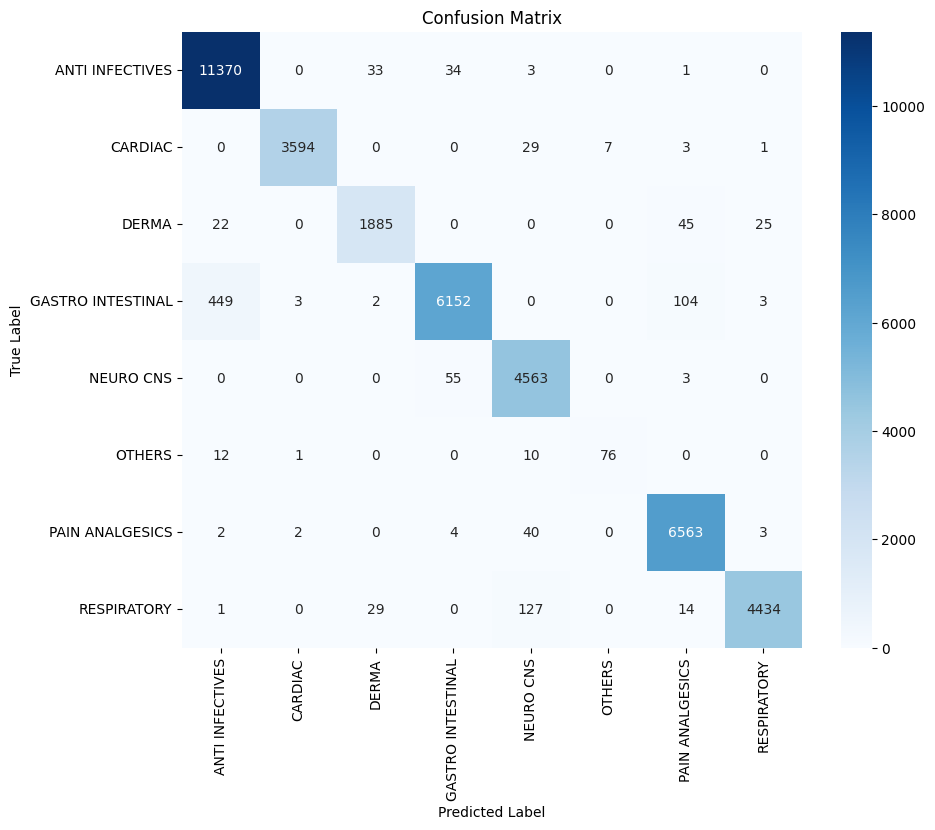

In [219]:
# สร้างกราฟ Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [220]:
import numpy as np

# กรองค่าที่ไม่ใช่ nan ออกจาก label_encoder.classes_
label_encoder.classes_ = label_encoder.classes_[~pd.isna(label_encoder.classes_)]


In [221]:
print(label_encoder.classes_)


['ANTI INFECTIVES' 'CARDIAC' 'DERMA' 'GASTRO INTESTINAL' 'NEURO CNS'
 'OTHERS' 'PAIN ANALGESICS' 'RESPIRATORY']


In [222]:
unique_y_test = np.unique(y_test_class)
unique_y_pred = np.unique(y_pred_class)
print(f"Unique classes in y_test_class: {len(unique_y_test)}, {unique_y_test}")
print(f"Unique classes in y_pred_class: {len(unique_y_pred)}, {unique_y_pred}")


Unique classes in y_test_class: 8, [0 1 2 3 4 5 6 7]
Unique classes in y_pred_class: 8, [0 1 2 3 4 5 6 7]


In [223]:
missing_classes_test = [cls for cls in unique_y_test if cls >= len(label_encoder.classes_)]
missing_classes_pred = [cls for cls in unique_y_pred if cls >= len(label_encoder.classes_)]

print(f"Missing classes in y_test_class: {missing_classes_test}")
print(f"Missing classes in y_pred_class: {missing_classes_pred}")


Missing classes in y_test_class: []
Missing classes in y_pred_class: []


In [224]:
labels = list(range(len(label_encoder.classes_)))  # กำหนด labels ให้ตรงกับจำนวนคลาสที่เหลืออยู่
report = classification_report(y_test_class, y_pred_class, target_names=label_encoder.classes_, labels=labels)
print(report)


                   precision    recall  f1-score   support

  ANTI INFECTIVES       0.96      0.99      0.98     11441
          CARDIAC       1.00      0.99      0.99      3634
            DERMA       0.97      0.95      0.96      1977
GASTRO INTESTINAL       0.99      0.92      0.95      6713
        NEURO CNS       0.96      0.99      0.97      4621
           OTHERS       0.92      0.77      0.84        99
  PAIN ANALGESICS       0.97      0.99      0.98      6614
      RESPIRATORY       0.99      0.96      0.98      4605

         accuracy                           0.97     39704
        macro avg       0.97      0.95      0.96     39704
     weighted avg       0.97      0.97      0.97     39704



In [225]:
# บันทึกโมเดลลงในไฟล์ .h5
model.save('classifier.h5')

In [226]:
# โหลดโมเดลจากไฟล์ .h5 (หากต้องการ)
loaded_model = load_model('classifier.h5')

In [227]:
# ประมวลผลข้อความ OCR
processed_text = process_text(cleaned_text2)
ocr_seq = tokenizer.texts_to_sequences([processed_text])
ocr_padded = pad_sequences(ocr_seq, maxlen=max_length, padding='post')

In [228]:
# ทำนายประเภทของข้อความ OCR โดยใช้โมเดลที่โหลด
predicted_type_loaded = loaded_model.predict(ocr_padded)
predicted_class_index = np.argmax(predicted_type_loaded, axis=-1)
predicted_class = label_encoder.inverse_transform([predicted_class_index[0]])

print(f"Predicted Therapeutic Class: {predicted_class[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Predicted Therapeutic Class: RESPIRATORY


In [229]:
# ดึงค่าของคอลัมน์ use0 และ sideEffect1 จากแถวที่ตรงกับ Therapeutic Class ที่ทำนายได้
matching_row = df[df['Therapeutic Class'] == predicted_class[0]]

In [ ]:
if not matching_row.empty:
    combined_value = (
        f"Therapeutic Class: {predicted_class[0]}\n"
        f"use0: {matching_row.iloc[0]['use0']}\n"
        f"sideEffect1: {matching_row.iloc[0]['sideEffect1']}"
    )
    print(f"Combined value:\n{combined_value}")
else:
    print("ไม่พบแถวที่ตรงกับ Therapeutic Class ที่ทำนายได้")

Combined value:
Therapeutic Class: RESPIRATORY
use0: Treatment,of,Cough,with,mucus
sideEffect1: Vomiting


In [231]:
# ฟังก์ชันคำนวณ % ความเหมือนโดยใช้ SequenceMatcher
def calculate_similarity(text1, text2):
    if pd.isna(text2):  # ตรวจสอบถ้าค่าใน Therapeutic Class เป็น NaN
        return 0  # ถ้าเป็น NaN ให้คืนค่า 0
    return difflib.SequenceMatcher(None, text1, text2).ratio() * 100

In [232]:
# คำนวณ % ความเหมือนกับทุก Therapeutic Class ใน dataset ที่ไม่ซ้ำกัน
similarities = []
unique_classes = set(df['Therapeutic Class'])  # กรองเอาเฉพาะค่าที่ไม่ซ้ำกัน

In [233]:
for class_text in unique_classes:
    similarity_percentage = calculate_similarity(predicted_class[0], class_text)
    similarities.append((class_text, similarity_percentage))

In [234]:
# จัดเรียง % ความเหมือนจากมากไปน้อย
similarities = sorted(similarities, key=lambda x: x[1], reverse=True)

In [235]:
# แสดง Therapeutic Class ที่มี % ความเหมือนสูงสุด
most_similar_class, max_similarity = similarities[0]
print(f"Most similar Therapeutic Class: {most_similar_class}, Similarity: {max_similarity:.2f}%")

Most similar Therapeutic Class: RESPIRATORY, Similarity: 100.00%


In [236]:
# แสดงผลทุก Therapeutic Class ที่คำนวณได้พร้อม % ความเหมือน
print("Similarities with all Therapeutic Classes:")
for class_text, similarity_percentage in similarities:
    print(f"Therapeutic Class: {class_text}, Similarity: {similarity_percentage:.2f}%")

Similarities with all Therapeutic Classes:
Therapeutic Class: RESPIRATORY, Similarity: 100.00%
Therapeutic Class: GASTRO INTESTINAL, Similarity: 35.71%
Therapeutic Class: CARDIAC, Similarity: 33.33%
Therapeutic Class: DERMA, Similarity: 25.00%
Therapeutic Class: OTHERS, Similarity: 23.53%
Therapeutic Class: PAIN ANALGESICS, Similarity: 23.08%
Therapeutic Class: NEURO CNS, Similarity: 20.00%
Therapeutic Class: ANTI INFECTIVES, Similarity: 15.38%
